# The Making of the Riva Hindi ASR Service

This notebook walks you through the end-to-end process that NVIDIA engineers and data scientists employed to develop the Riva Hindi Automatic Speech Recognition (ASR) service, from raw transcribed audio data to a ready-to-serve Riva ASR service.

## Overview

The following diagram provides a high-level overview of the end-to-end engineering workflow required to realize the Riva Hindi ASR service.

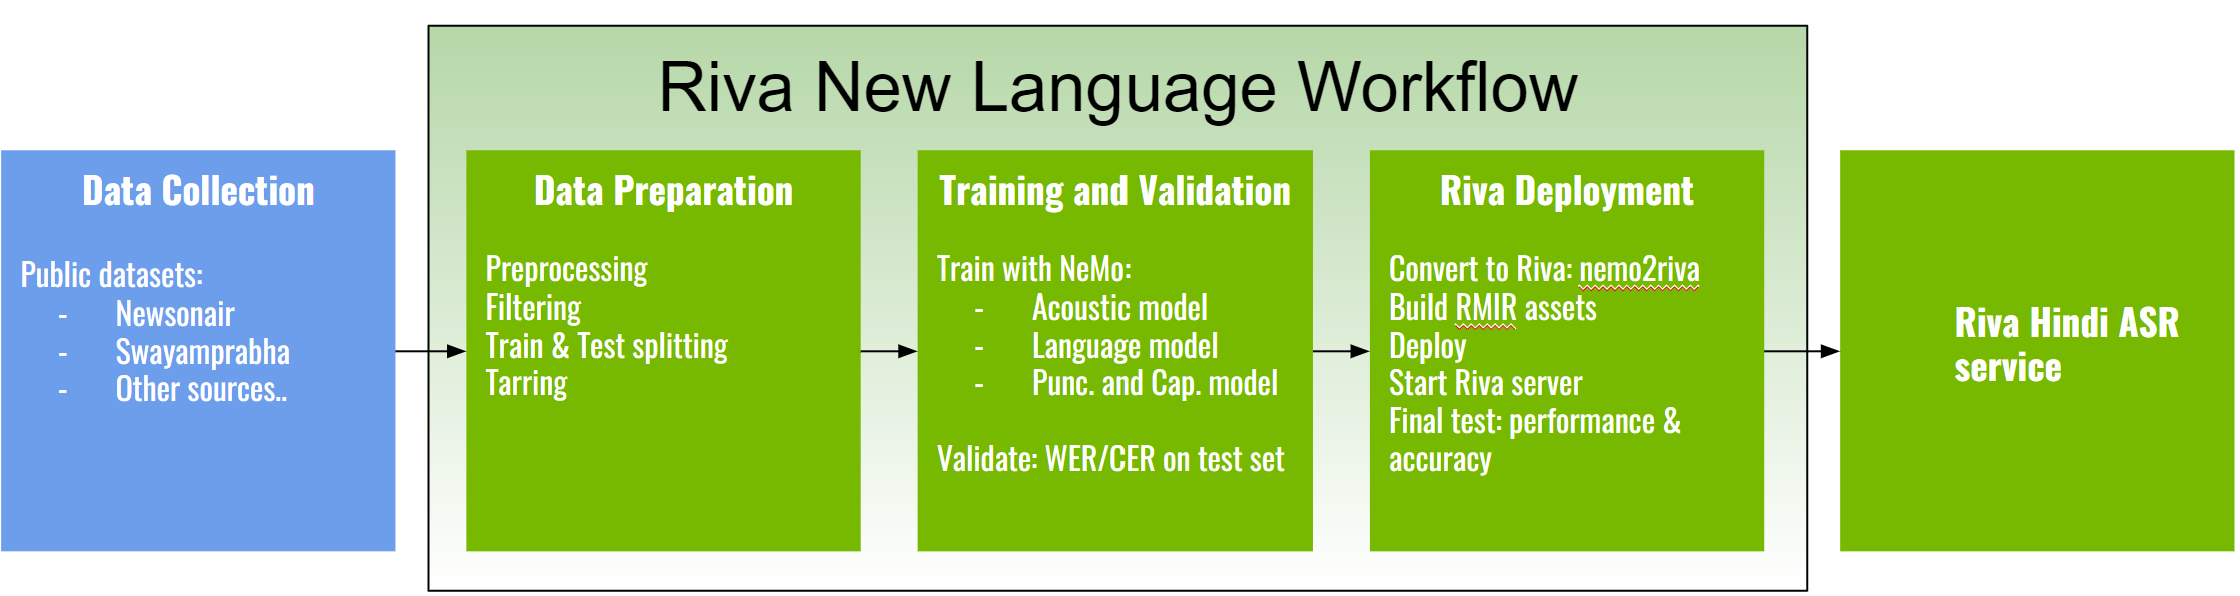

In [3]:
from IPython.display import Image
Image(filename='Hindi-workflow.png')

Beyond the data collection phase, the new language workflow for Riva is divided into four major stages:

* Data collection
* Data preparation
* Training and validation
* Riva deployment

In the next sections, we look deeper into each of these stages.

## 1. Data collection

When adapting Riva to a new language, a large amount of high-quality transcribed audio data is critical for training high-quality acoustic models.

For Hindi, we can readily leverage the [Hindi-Labelled ULCA-asr-dataset-corpus](https://github.com/Open-Speech-EkStep/ULCA-asr-dataset-corpus#hindi-labelled--total-duration-is-239876-hours) public dataset which contains:

* Newsonair (791 hours)
* Swayamprabha (80 hours)
* Multiple Sources (1627 hours)

The datasets amount to ~2400 hours of transcribed Hindi speech audio data. The audio samples belong to the following genders:
* Male: ~207k samples
* Female: ~207k samples
* Non-specified: ~1.3M samples

The dataset has a total of 1.7M utterances/samples with 181 characters and a vocabulary size of 107k.
The dataset contains audio samples with a signal to noise (SNR) ratio > 15 only i.e. there are no noisy audio samples present in the dataset.

## 2. Data preparation

The data preparation phase carries out a series of preparation steps required to convert the diverse raw audio datasets into a uniform format that can be efficiently digested by NVIDIA NeMo Toolkit. These steps are:

### 2.1. Data preprocessing

**Audio data**:
Audio data acquired from various sources are inherently heterogeneous (file format, sample rate, bit depth, number of audio channels...). Therefore, as a preprocessing step, we need to build a separate data ingestion pipeline for each source and convert the audio data into a common format with the following characteristics:

* Wav format
* Bit depth: 16 bits
* Sample rate of 16 Khz
* Single audio channel

**Text data**:
Text normalization converts text from written form into its verbalized form. It is used as a preprocessing step for preprocessing ASR training transcripts. For Hindi text normalization, we primarily leverage the NeMo text normalization library. If it is not available, we develop a simpler, makeshift normalization code within Riva.

We've developed text normalization script for Hindi language which performs:

* Filtering of the character set - many characters (more than 50%) do not belong to the Hindi alphabet set. 
* Convert numbers to their text counterparts - "200" is converted to "दो सौ"
* Transliteration - English to Hindi

Dataset ingestion scripts convert various datasets into the standard manifest format expected by NeMo.

### 2.2. Data cleaning/filtering

This step is to filter outlying samples in the datasets. The data cleaning and filtering process is to filter out:

- samples that are too long, too short, or empty are filtered out. For Hindi, we've filtered out audio samples that are shorter than 1 and longer than 15 seconds.

- samples that are considered 'noisy', that is, samples having very high WER (word error rate) or CER (character error rate) with regard to a previously trained Hindi ASR model. Since we didn't find any pre-trained Hindi ASR model, we first trained a model on the whole dataset and then used that to perform this filtering.

### 2.3. Train and Test splitting

This step is a staple of any deep learning and machine learning development pipeline to ensure that the model is learning to generalize without overfitting the training data. We used a 90:10 ratio for train and test split. 

### 2.4. Tarring

If the experiments are run on a cluster with datasets stored on a distributed file system, you will likely want to avoid constantly reading multiple small files and would prefer tarring your audio files. You can easily convert your existing NeMo-compatible ASR datasets using the conversion [script](https://github.com/NVIDIA/NeMo/blob/v1.7.0/scripts/speech_recognition/convert_to_tarred_audio_dataset.py).

## 3. Training and validation

The models in an ASR pipeline include:

- **Acoustic model** - maps raw audio input to probabilities over text tokens at each time step. This matrix of probabilities is fed into a decoder that converts probabilities into a sequence of text tokens.
- **Language model** - optionally used in the decoding phase of the acoustic model output.
**Punctuation and Capitalization (P&C) model** - formats the raw transcript, augmenting with punctuation and capitalization.


### 3.1. Acoustic model

The acoustic model is by far the most important part of an ASR service. These are the most resource intensive models, requiring a large amount of data to train on powerful GPU servers or cluster. They also have the largest impact on the overall ASR quality.

**Model architecture**:\
The models we experimented with for the Hindi ASR pipeline include [Citrinet-1024](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/asr/models.html#citrinet) and [Conformer-Medium/Large](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/asr/models.html#conformer-ctc). The final model chosen for deployment of the Riva Hindi ASR service (ver. 22.04) was a [Conformer-CTC model](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/stt_hi_conformer_ctc_medium).

Conformer-CTC is a CTC-based variant of the Conformer model introduced in this [paper](https://arxiv.org/abs/2005.08100v1). Conformer-CTC has a similar encoder as the original Conformer but uses CTC loss and decoding instead of RNNT/Transducer loss, which makes it a non-autoregressive model. We also drop the LSTM decoder and instead use a linear decoder on top of the encoder. This model uses the combination of self-attention and convolution modules to achieve the best of the two approaches; the self-attention layers can learn the global interaction while the convolutions efficiently capture the local correlations. The self-attention modules support both regular self-attention with absolute positional encoding and also Transformer-XL’s self-attention with relative positional encodings.

**Training from scratch vs. Cross-Language transfer learning**:\
Cross-language transfer learning is especially helpful when training new models for low-resource languages. Even when a substantial amount of data is available, cross-language transfer learning can help boost the performance further. It is based on the idea that phoneme representation can be shared across different languages. Refer to [this](https://github.com/NVIDIA/NeMo/blob/main/tutorials/asr/ASR_CTC_Language_Finetuning.ipynb) notebook for an example of cross-language transfer learning.

We started the training of the Hindi Conformer-CTC medium model from a [NeMo En Conformer-CTC medium model](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/stt_en_conformer_transducer_medium) as initialization. The Hindi model's encoder is initialized with English model's encoder weights and the decoder is initialized from scratch. The process is illustrated in the following diagram.

While training the previous models, Conformer-Medium converged the best. Conformer-Large also converged but started to overfit after 100k steps. Unfortunately, Citrinet-1024 didn't converge in our experiments.


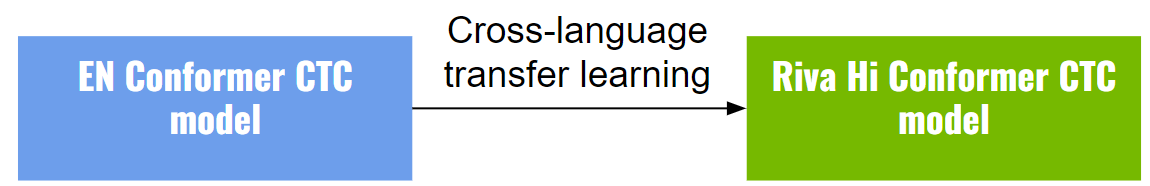

In [5]:
from IPython.display import Image
Image(filename='transfer-learning.png')

**Training script**:\
We leverage NeMo training [scripts](https://github.com/NVIDIA/NeMo/blob/v1.7.2/examples/asr/speech_to_text.py). You may find the example config files for [**Citrinet**](https://github.com/NVIDIA/NeMo/blob/v1.7.2/examples/asr/conf/citrinet/citrinet_1024.yaml) and [**Conformer**](https://github.com/NVIDIA/NeMo/blob/v1.7.2/examples/asr/conf/conformer/conformer_ctc_bpe.yaml)

**Hyper-parameter setting**:\
For model fine-tuning, we employed an Adam optimizer with learning rate 5.0 and spec augmentation time 5.0

**Training environment**: We trained the models on a GPU cluster comprising 8 x A100 40GB GPUs.

### 3.2. Language model

Language model, combined with beam search in the decoding phase can further improve the quality of the ASR pipeline. In our experiments, we observed an additional WER reduction of 3-5% by using a simple n-gram model:\

The language models supported by Riva are n-gram model, which can be trained with the Kenlm toolkit. See Riva [documentation](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/asr/asr-customizing.html#training-language-models) for details on how to train and deploy a custom language model.

**Training data**: We create training set by combining all the transcript text in our ASR set, normalizing, cleaning then tokenizing (using the same tokenizer used for ASR transcript preprocessing mentioned above). The pretrained LMs and their corresponding text corpus is available on [Github](https://github.com/Open-Speech-EkStep/vakyansh-models#language-models). The hindi_lm_dataset can be downloaded from [this page](https://storage.googleapis.com/vakyansh-open-models/language_model_text/hindi.zip).

### 3.3. Punctuation and capitalization model

The Punctuation and Capitalization model consists of the pre-trained Bidirectional Encoder Representations (BERT) from Transformers followed by two token classification heads. One classification head is responsible for the punctuation task, the other one handles the capitalization task.

We would use a BERT cased checkpoint on a subset of data from [this](https://github.com/Open-Speech-EkStep/vakyansh-models#punctuation-models) dataset, specifically the [Hindi punctuation data](https://storage.googleapis.com/vakyansh-open-models/punctuation_models/training_data/hindi_new.zip).

We employed a BERT-base model for the task and leverage NeMo [script](https://github.com/NVIDIA/NeMo/blob/v1.7.2/examples/nlp/token_classification/punctuation_capitalization_train_evaluate.py) for the training part. Also see the NeMo [tutorial](https://github.com/NVIDIA/NeMo/blob/v1.7.2/tutorials/nlp/Punctuation_and_Capitalization.ipynb) on this topic.


## 4. Model Testing

In addition to evaluating our model on the train test split, we've also evaluated our model on other public blind datasets to test its generalizability:

* IIT-Madras ASR Challenge 
* Interspeech MUCS Challenge
* IIT-Madras ASR Challenge
* etc.

We've observed very competetive WER, as low as 12.78, on these blind test sets.

## 5. Riva Deployment

With all the models trained, now it's the time to deploy the Riva service.

### BYO Hindi models

Given the final `.nemo` model, here are the steps that need to be done to deploy on Riva:

* Download RIVA Quickstart scripts – it provides `nemo2riva`, `servicemaker`, `riva-speech-server` and `riva-speech-client` images.
* Build `.riva` assets: using `nemo2riva` command in the `servicemaker` container. See examples of build command for different models and for offline and online ASR pipelines in the [Riva build documentation page]().

* Build `RMIR` assets: use the `riva-build` tool in the `servicemaker` container.

* Deploy the model and start the server.

### Riva pretrained Hindi models on NGC

All Riva Hindi assets are published on NGC (including `.nemo`, `.riva`, `.tlt` and `.rmir` assets). You can use these models as starting points for your development.

**Acoustic models**:

* Conformer-Medium ASR Hindi:
    * [Riva deployable version (.riva format)]()
    * [Tao trainable version (.tlt format)]()
    * [Nemo version (.nemo format)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/stt_hi_conformer_ctc_medium)

**Language model** - \
These models are simple [6-gram language models]() trained with Kneser-Ney smoothing using KenLM. This directory also contains the decoder dictionary used by the Flashlight decoder.

## Conclusion
In this notebook, we have guided you through the steps to realize the Riva Hindi ASR service, from raw data to a ready-to-use service.

You can follow the same process to setup a new Hindi ASR service using your own data, or use the resources in this notebook to fine-tune parts of the pipeline with your own model and data.